# Forecasting 

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 09 - More Advanced DL Applications/1- Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->



Suppose you are studying the number of active users per hour on your website, or the
daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics.

 In all these cases, the data will be a sequence of one or
more values per time step. 

This is called a time series. In the first two examples there
is a single value per time step, so these are univariate time series, while in the financial
example there are multiple values per time step (e.g., the company’s revenue, debt,
and so on), so it is a multivariate time series. A typical task is to predict future values,
which is called forecasting. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. 

This is called imputation. For example, Figure below shows 3 univariate time series, each of them 50 time steps long, and
the goal here is to forecast the value at the next time step (represented by the X) for
each of them.

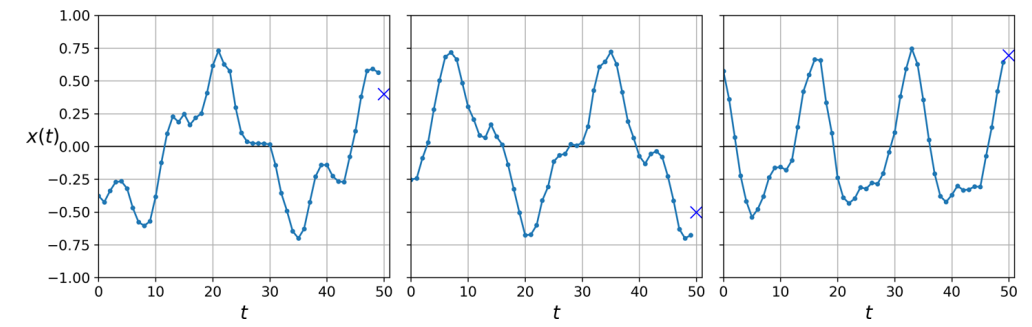

# Download the Dataset From Kaggle

In [1]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
# download data
! kaggle datasets download -d salmanfaroz/amazon-stock-price-1997-to-2020

  0% 0.00/116k [00:00<?, ?B/s]
100% 116k/116k [00:00<00:00, 13.0MB/s]


In [3]:
# unzip data
! unzip /content/amazon-stock-price-1997-to-2020.zip

Archive:  /content/amazon-stock-price-1997-to-2020.zip
  inflating: Amazon.csv              


# Import the Libraries

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Read the CSV File 

In [5]:
# read the csv file using pandas
data_df = pd.read_csv("/content/Amazon.csv")
# show the dataset
data_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


We can not use the CSV file have 

In [6]:
# drop the columns that are not required
data_df.drop(
    columns=["Date", "Open", "High", "Adj Close", "Low", "Volume"], inplace=True
)
data_df

,Close
0,1.958333
1,1.729167
2,1.708333
3,1.635417
4,1.427083
...,...
5837,3055.209961
5838,3000.330078
5839,3033.530029
5840,3051.879883


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffad24dba50>]],
      dtype=object)

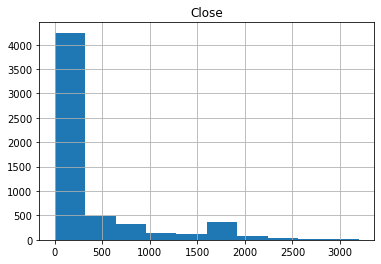

In [7]:
# show the histagram of the dataset
data_df.hist()

# Preprocessing the Data

In [8]:
# normalize the dataset using min-max scaling
x_normalizer = preprocessing.MinMaxScaler()
x_normalizer.fit(data_df.Close.to_numpy().reshape(-1, 1))
x_norm = x_normalizer.transform(data_df.Close.to_numpy().reshape(-1, 1))

(array([4246.,  486.,  320.,  148.,  114.,  370.,   81.,   41.,   15.,
          21.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

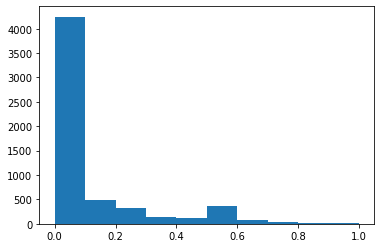

In [9]:
# show the histagram of the dataset
plt.hist(x_norm)

# Create Time Series Data

In mathematics, a time series is a series of data points indexed in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data.

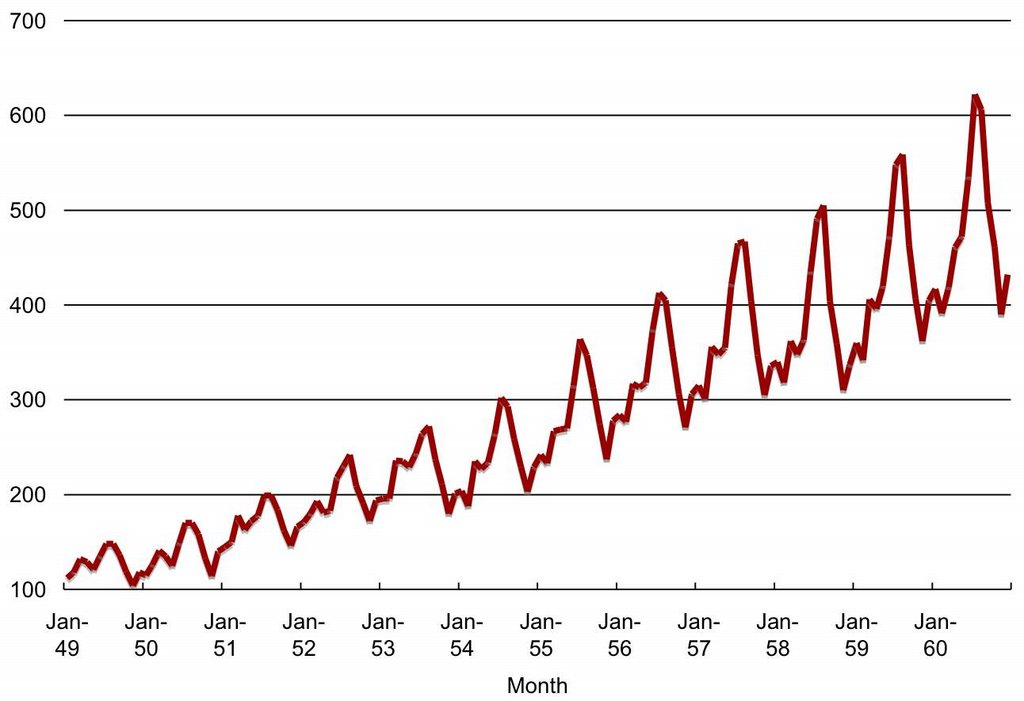

## Timeseries Generator
This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation. Arguments: data: Indexable generator (such as list or Numpy array) containing consecutive data points (timesteps). The data should be at 2D, and axis 0 is expected to be the time dimension. targets: Targets corresponding to timesteps in data. It should have same length as data. length: Length of the output sequences (in number of timesteps). sampling_rate: Period between successive individual timesteps within sequences. For rate r, timesteps data[i], data[i-r], ... data[i - length] are used for create a sample sequence. stride: Period between successive output sequences. For stride s, consecutive output samples would be centered around data[i], data[i+s], data[i+2*s], etc. start_index: Data points earlier than start_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation. end_index: Data points later than end_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation. shuffle: Whether to shuffle output samples, or instead draw them in chronological order. reverse: Boolean: if true, timesteps in each output sample will be in reverse chronological order. batch_size: Number of timeseries samples in each batch (except maybe the last one). 
[Read More.](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator)

In [10]:
# create the time series dataset using Time Series Data Generator from keras make sure the input is the normalized dataset and the target is the data before normalized
time_serises = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_norm, data_df.Close, length=16, batch_size=32
)

In [11]:
# get the first batch of the dataset
x, y = time_serises[0]

In [12]:
# show the first 3 time series from first batch
x[:3]

array([[[1.75857959e-04],
        [1.04212099e-04],
        [9.76988660e-05],
        [7.49024391e-05],
        [9.76988660e-06],
        [0.00000000e+00],
        [3.25662763e-05],
        [5.86193196e-05],
        [4.23361629e-05],
        [3.41946031e-05],
        [3.25662763e-05],
        [3.58228927e-05],
        [2.60530061e-05],
        [6.51323289e-06],
        [4.55927793e-05],
        [8.14157093e-05]],

       [[1.04212099e-04],
        [9.76988660e-05],
        [7.49024391e-05],
        [9.76988660e-06],
        [0.00000000e+00],
        [3.25662763e-05],
        [5.86193196e-05],
        [4.23361629e-05],
        [3.41946031e-05],
        [3.25662763e-05],
        [3.58228927e-05],
        [2.60530061e-05],
        [6.51323289e-06],
        [4.55927793e-05],
        [8.14157093e-05],
        [9.11855959e-05]],

       [[9.76988660e-05],
        [7.49024391e-05],
        [9.76988660e-06],
        [0.00000000e+00],
        [3.25662763e-05],
        [5.86193196e-05],
        

In [13]:
# show the first 2 tragets time series from first batch
y[:2]

array([1.6875    , 1.58333337])

In [14]:
# print the shape of the dataset
# we can notice that the dataset is of shape (batch_size,length,1) and the target is of shape (batch_size)
print(x.shape)
print(y.shape)

(32, 16, 1)
(32,)


In [15]:
# create the data from the time series dataset generator
# create empty nummpy array to store the data
x_data = np.array([])
# create empty nummpy array to store the target
y_data = np.array([])
# loop through the dataset and append the data and target to the empty arrays
for x, y in time_serises:
    # append the data to the x_data array
    x_data = np.append(x_data, x)
    # append the target to the y_data array
    y_data = np.append(y_data, y)

In [16]:
# make sure the data is of shape (batch_size,length,1) and the target is of shape (batch_size,1)
x = x_data.reshape(-1, 16, 1)
y = y_data.reshape(-1, 1)

In [17]:
# print the shape of the dataset
x.shape

(5826, 16, 1)

In [18]:
# print the shape of the target
y.shape

(5826, 1)

In [ ]:
# get the max value of the dataset
x_normalizer.data_max_

# Create the Data Pipeline

In [20]:
# create the data pipeline function
def dataset_creater(x, y):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(5826, reshuffle_each_iteration=True)
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data


# create the train pipeline
train_dataset = dataset_creater(x[:-100], y[:-100])

# Create the Forcasting Model

In [21]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input((16, 1)),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 3200),
    ]
)

In [23]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError())
model.fit(train_dataset, epochs=10, validation_data=(x[-100:], y[-100:]))

Epoch 1/10
179/179 [==============================] - 10s 30ms/step - loss: 900.1078 - val_loss: 21445.6641
Epoch 2/10
179/179 [==============================] - 3s 18ms/step - loss: 832.1502 - val_loss: 43727.2734
Epoch 3/10
179/179 [==============================] - 4s 20ms/step - loss: 555.4286 - val_loss: 55054.2461
Epoch 4/10
179/179 [==============================] - 4s 21ms/step - loss: 475.9383 - val_loss: 26064.3750
Epoch 5/10
179/179 [==============================] - 3s 18ms/step - loss: 462.1893 - val_loss: 12956.2988
Epoch 6/10
179/179 [==============================] - 3s 17ms/step - loss: 414.1896 - val_loss: 15336.4072
Epoch 7/10
179/179 [==============================] - 4s 22ms/step - loss: 364.5642 - val_loss: 26751.8633
Epoch 8/10
179/179 [==============================] - 3s 18ms/step - loss: 333.2659 - val_loss: 6194.2329
Epoch 9/10
179/179 [==============================] - 3s 18ms/step - loss: 363.8042 - val_loss: 9688.1982
Epoch 10/10
179/179 [=================

In [24]:
pred = model.predict(x[-300:])

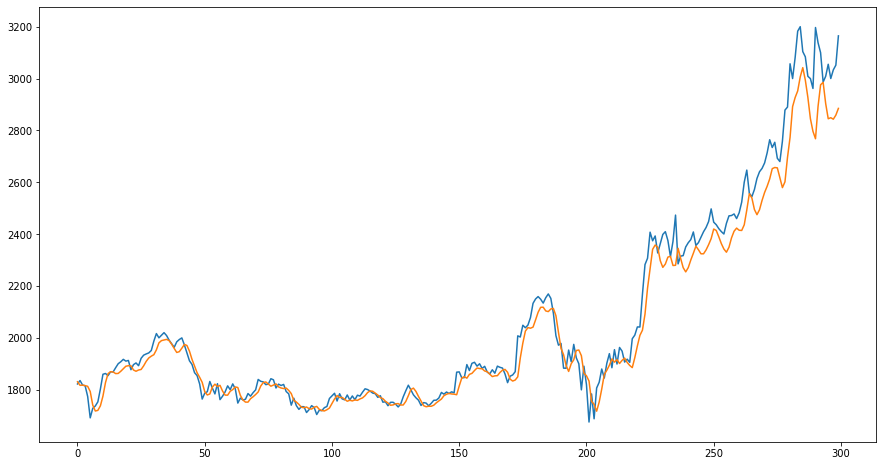

In [25]:
plt.figure(figsize=(15, 8))
true_y = y[-300:]
plt.plot(true_y)
plt.plot(pred.reshape(-1))

In [26]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input((16, 1)),
        tf.keras.layers.Conv1D(
            16, kernel_size=3, padding="causal", activation=tf.nn.leaky_relu
        ),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 3200),
    ]
)

In [27]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError())
model.fit(train_dataset, epochs=10, validation_data=(x[-100:], y[-100:]))

Epoch 1/10
179/179 [==============================] - 14s 32ms/step - loss: 12627.7949 - val_loss: 35673.0742
Epoch 2/10
179/179 [==============================] - 4s 20ms/step - loss: 725.9387 - val_loss: 54600.0312
Epoch 3/10
179/179 [==============================] - 3s 19ms/step - loss: 1001.3983 - val_loss: 34377.2266
Epoch 4/10
179/179 [==============================] - 4s 20ms/step - loss: 715.9274 - val_loss: 38757.0234
Epoch 5/10
179/179 [==============================] - 3s 19ms/step - loss: 723.1519 - val_loss: 18660.0000
Epoch 6/10
179/179 [==============================] - 3s 19ms/step - loss: 815.7852 - val_loss: 32332.6172
Epoch 7/10
179/179 [==============================] - 4s 20ms/step - loss: 704.3836 - val_loss: 40890.6016
Epoch 8/10
179/179 [==============================] - 3s 19ms/step - loss: 565.2032 - val_loss: 21420.5430
Epoch 9/10
179/179 [==============================] - 4s 21ms/step - loss: 514.3823 - val_loss: 21296.4434
Epoch 10/10
179/179 [============

In [28]:
pred = model.predict(x[-300:])

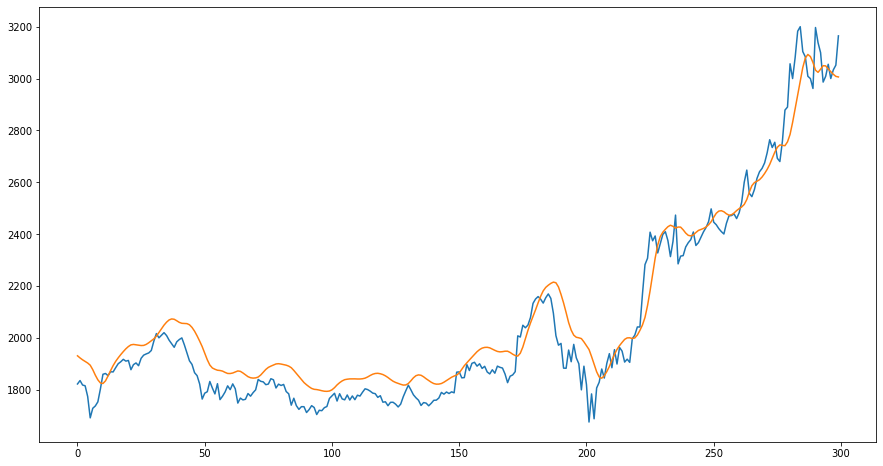

In [29]:
plt.figure(figsize=(15, 8))
true_y = y[-300:]
plt.plot(true_y)
plt.plot(pred.reshape(-1))

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input((16, 1)),
        tf.keras.layers.Conv1D(
            16, kernel_size=3, padding="causal", activation=tf.nn.leaky_relu
        ),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 3200),
    ]
)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.Huber())
model.fit(train_dataset, epochs=10, validation_data=(x[-100:], y[-100:]))

Epoch 1/10
179/179 [==============================] - 9s 26ms/step - loss: 36.3381 - val_loss: 131.2507
Epoch 2/10
179/179 [==============================] - 6s 35ms/step - loss: 15.2581 - val_loss: 155.4907
Epoch 3/10
179/179 [==============================] - 4s 20ms/step - loss: 15.7316 - val_loss: 104.1999
Epoch 4/10
179/179 [==============================] - 4s 20ms/step - loss: 13.1673 - val_loss: 139.7122
Epoch 5/10
179/179 [==============================] - 4s 21ms/step - loss: 12.6699 - val_loss: 78.0851
Epoch 6/10
179/179 [==============================] - 4s 21ms/step - loss: 11.1498 - val_loss: 78.2680
Epoch 7/10
179/179 [==============================] - 4s 20ms/step - loss: 11.1673 - val_loss: 100.0145
Epoch 8/10
179/179 [==============================] - 4s 21ms/step - loss: 9.1106 - val_loss: 54.6154
Epoch 9/10
179/179 [==============================] - 4s 20ms/step - loss: 9.3023 - val_loss: 53.3734
Epoch 10/10
179/179 [==============================] - 4s 21ms/step - 

In [ ]:
pred = model.predict(x[-300:])

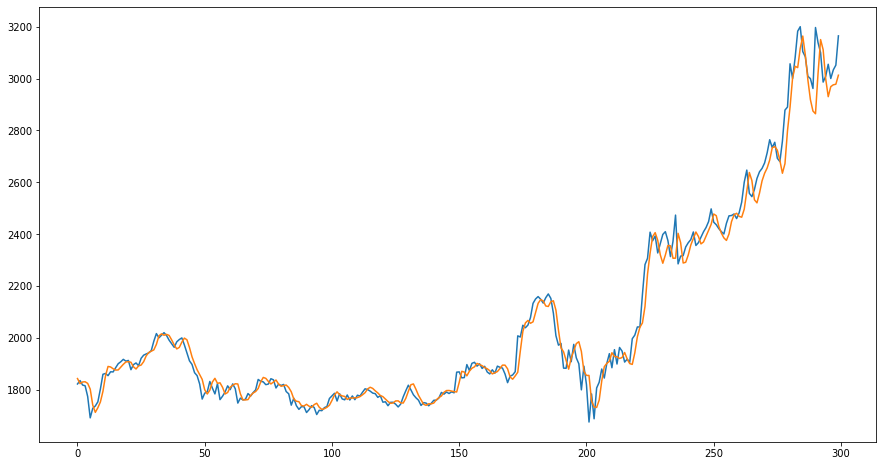

In [ ]:
plt.figure(figsize=(15, 8))
true_y = y[-300:]
plt.plot(true_y)
plt.plot(pred.reshape(-1))

In [ ]:
x[-1]

array([[0.99456947],
       [1.        ],
       [0.96998691],
       [0.96373418],
       [0.94024585],
       [0.93744143],
       [0.92558316],
       [0.9990121 ],
       [0.98070722],
       [0.9687082 ],
       [0.93326778],
       [0.94025829],
       [0.95473337],
       [0.93757592],
       [0.94795543],
       [0.95369226]])

In [ ]:
a = [
    [0.99456947],
    [1.0],
    [0.96998691],
    [0.96373418],
    [0.94024585],
    [0.93744143],
    [0.92558316],
    [0.9990121],
    [0.98070722],
    [0.9687082],
    [0.93326778],
    [0.94025829],
    [0.95473337],
    [0.93757592],
    [0.94795543],
    [0.95369226],
]


def make_pred(x, days=1):
    pred_list = []
    for i in range(days):

        pred = model.predict([x])
        pred_list.append(pred.reshape(-1)[0])
        x.pop(0)
        x.append([pred[0][0] / 3200])

    return pred_list


pred = make_pred(a)
true_y = y[-1]
print(pred)
print(true_y)

[3013.0444]
[3164.67993164]
